<a href="https://colab.research.google.com/github/Rekt77/kisa_insuretech/blob/master/kisa_insure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize
from wordcloud import WordCloud, STOPWORDS

In [0]:
df = pd.read_excel("/content/drive/My Drive/insuretech/insurance/kisa_insurance.xlsx")

In [337]:
new_columns = ['c_idx','s_idx','sex','age','occupation','middle_div','small_div','sub_div','city','district','ins_cat','ins_name','gar_name','long_gar_cat','sp_term']
df.columns = new_columns
df.head()

,c_idx,s_idx,sex,age,occupation,middle_div,small_div,sub_div,city,district,ins_cat,ins_name,gar_name,long_gar_cat,sp_term
0,2,26394,여자,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해후유장해,교통상해50%이상후유장해(1회한)
1,2,26394,여자,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,기타/인,비용기타,행정소송법률비용손해(실손)
2,2,26394,여자,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해사망·후유장해,상해사망
3,2,26394,여자,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,상해,상해사망·후유장해,교통상해사망
4,2,26394,여자,21,"주부, 학생 및 기타 비경제활동인구","고등학생 및 주부, 무직",고등학생,고등학생,서울,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,기타/인,비용기타,법률비용손해(실손)


In [338]:
# 데이터의 값을 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103234 entries, 0 to 103233
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   c_idx         103234 non-null  int64 
 1   s_idx         103234 non-null  int64 
 2   sex           103234 non-null  object
 3   age           103234 non-null  int64 
 4   occupation    103234 non-null  object
 5   middle_div    103234 non-null  object
 6   small_div     103234 non-null  object
 7   sub_div       103234 non-null  object
 8   city          103234 non-null  object
 9   district      103234 non-null  object
 10  ins_cat       103234 non-null  object
 11  ins_name      103234 non-null  object
 12  gar_name      101472 non-null  object
 13  long_gar_cat  103234 non-null  object
 14  sp_term       103234 non-null  object
dtypes: int64(3), object(12)
memory usage: 11.8+ MB


In [0]:
from collections import Counter

# occupation,age,sex를 추출
pop_job = df.loc[:,["occupation","age","sex"]]

# Counter에 occupation의 값 넣고 값 확인
# 직업별 출현횟수 딕셔너리로 리턴
# 단어:출현횟수
job_freq = Counter(pop_job["occupation"])

# 직업별 출현횟수를 키로 job_map을 제작
job_map = {k:i for i,k in enumerate(job_freq.keys())}

# 숫자로 치환된 직업 데이터가 저장된 oocupation_mapped를 생성
pop_job["occupation_mapped"] = pop_job["occupation"].replace(job_map)

# pop_job을 occupation_mapped를 기준으로 그루핑(인덱스화 x)
# count를 하면 직업(숫자)별 사람 수를 매핑 가능 ㄱ
pop_job_counts = pop_job.groupby("occupation_mapped",as_index=False).count().sort_values("occupation",ascending=False)


# 1.Feature
 - long_gar_cat&sp_term
  - 보험 가입 시 증권번호가 생성되고 고객번호랑은 별개
  - 같은 고객이 여러개의 보험을 가입했을 경우가 있으므로 증권번호를 기준으로 데이터를 정제
  - 증권번호별 보험당 특약개수를 종합
  - long_gar & sp_term == drop

 - SEX
   - 남자 : 0
   - 여자 : 1


In [340]:
pop_col = ["c_idx","s_idx","sex","age","occupation","district","ins_cat","ins_name","gar_name"]
pop_df = df[pop_col]

# 증권 번호를 불러와서 중복된 것들을 전부제거
# 각 데이터당 1개의 고유값만 남음
sidxs = df["s_idx"].drop_duplicates()

# 중복되지 않은 증권번호를 이터레이팅
for sidx in sidxs:
  # row중에 sidx와 s_idx가 같은것을 고르고 그중에 gar_name에,
  # df["s_idx"]==sidx 마스크를 만족하는 row가 몇개인지 카운팅하여 삽입
  pop_df.loc[df["s_idx"]==sidx,"gar_name"] = int(len(pop_df[pop_df["s_idx"]==sidx]))

# 중복된 행을 전부제거하고 고유 행만 남김
pop_df = pop_df.drop_duplicates()
pop_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,c_idx,s_idx,sex,age,occupation,district,ins_cat,ins_name,gar_name
0,2,26394,여자,21,"주부, 학생 및 기타 비경제활동인구",노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,6
6,4,20024,남자,21,"주부, 학생 및 기타 비경제활동인구",도봉구,장기/질병,무배당 프로미라이프 참좋은치아사랑보험1904,7
13,8,27841,남자,21,"주부, 학생 및 기타 비경제활동인구",동대문구,장기/질병,무배당 프로미라이프 참좋은행복플러스+종합보험1911,24
37,15,16512,남자,20,"주부, 학생 및 기타 비경제활동인구",금천구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,10
47,21,27840,여자,18,"주부, 학생 및 기타 비경제활동인구",동대문구,장기/상해,무배당 프로미라이프 아이(I)러브(LOVE)건강보험2001,23


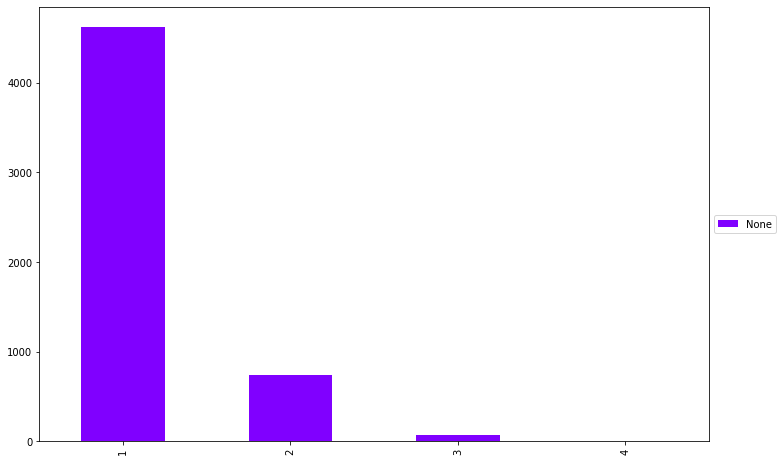

In [341]:
# 고객 한명이 최대 몇개의 보험을 들었는지
pivot = pd.crosstab(pop_df["c_idx"],pop_df["s_idx"]).sum(axis=1).sort_values(ascending=False)

pivot.value_counts().plot(kind='bar',
            stacked=True,
            colormap='rainbow',
            figsize=(12,8)).legend(loc='center left',
                                   bbox_to_anchor=(1, 0.5))

In [342]:
# column name 변경
pop_df.columns = ["c_idx","s_idx","sex","age","occupation","gis","ins_cat","ins_name","gar_count"]
pop_df.head()

,c_idx,s_idx,sex,age,occupation,gis,ins_cat,ins_name,gar_count
0,2,26394,여자,21,"주부, 학생 및 기타 비경제활동인구",노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,6
6,4,20024,남자,21,"주부, 학생 및 기타 비경제활동인구",도봉구,장기/질병,무배당 프로미라이프 참좋은치아사랑보험1904,7
13,8,27841,남자,21,"주부, 학생 및 기타 비경제활동인구",동대문구,장기/질병,무배당 프로미라이프 참좋은행복플러스+종합보험1911,24
37,15,16512,남자,20,"주부, 학생 및 기타 비경제활동인구",금천구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,10
47,21,27840,여자,18,"주부, 학생 및 기타 비경제활동인구",동대문구,장기/상해,무배당 프로미라이프 아이(I)러브(LOVE)건강보험2001,23


In [343]:
sex_map = {"남자":0,"여자":1}

pop_df["sex"] = pop_df["sex"].replace(sex_map)
pop_df.head()

,c_idx,s_idx,sex,age,occupation,gis,ins_cat,ins_name,gar_count
0,2,26394,1,21,"주부, 학생 및 기타 비경제활동인구",노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,6
6,4,20024,0,21,"주부, 학생 및 기타 비경제활동인구",도봉구,장기/질병,무배당 프로미라이프 참좋은치아사랑보험1904,7
13,8,27841,0,21,"주부, 학생 및 기타 비경제활동인구",동대문구,장기/질병,무배당 프로미라이프 참좋은행복플러스+종합보험1911,24
37,15,16512,0,20,"주부, 학생 및 기타 비경제활동인구",금천구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,10
47,21,27840,1,18,"주부, 학생 및 기타 비경제활동인구",동대문구,장기/상해,무배당 프로미라이프 아이(I)러브(LOVE)건강보험2001,23


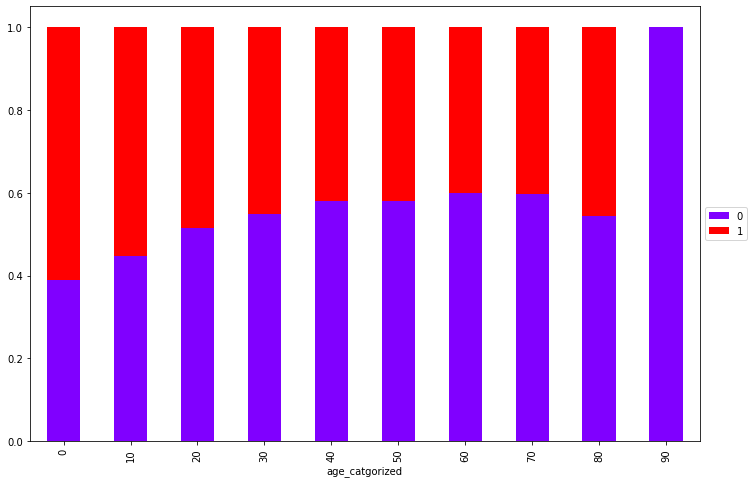

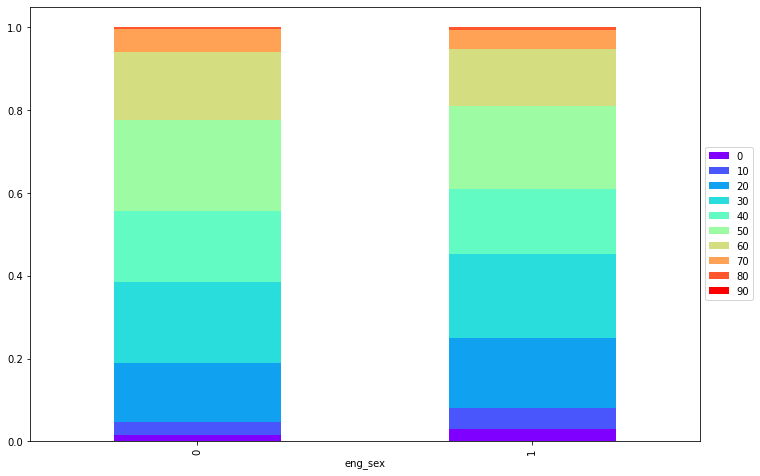

In [344]:
# 나이대-성별그래프
# 컬럼=성별
# 인덱스=나이 카테고리
ctab_age = pd.crosstab(pop_age['age_catgorized'],
                     pop_age['eng_sex']).apply(lambda x: x/x.sum(), axis=1)

# bar plot(나이 카테고리를 x축으로)
ctab_age.plot(kind='bar',
            stacked=True,
            colormap='rainbow',
            figsize=(12,8)).legend(loc='center left',
                                   bbox_to_anchor=(1, 0.5))

# 나이대-성별그래프
# 컬럼=나이 카테고리
# 인덱스=성별
ctab_sex = pd.crosstab(pop_age['eng_sex'],
                     pop_age['age_catgorized']).apply(lambda x: x/x.sum(), axis=1)

# bar plot(나이 카테고리를 x축으로)
ctab_sex.plot(kind='bar',
            stacked=True,
            colormap='rainbow',
            figsize=(12,8)).legend(loc='center left',
                                   bbox_to_anchor=(1, 0.5))

 - occupation
  - 직업 군
  - 상세직업(중,소,세)는 결측치가 너무 많고 대체값이 존재하지 않기 때문에 열 삭제
  --------------
   * 주부, 학생 및 기타 비경제활동인구': 0,
   * 자연과학, 공학, 컴퓨터 및 통신 관련분야': 1,
   * 서비스 관련 분야 (음식, 숙박, 여행 등)': 2,
   * 농림어업, 광업, 축산업 관련 분야': 3,
   * 교육, 의료, 종교, 문화예술, 스포츠, 사회복지 관련 분야': 4,
   * 화학, 섬유, 식품, 설비 및 기타 제조 (기능, 생산직 관련 분야)': 5
   * 행정, 금융, 사무관리,법률 관련 분야': 6,
   * 전기, 전자, 기계, 금속 (기능, 생산직 관련 분야)': 7,
   * 판매 관련 분야': 8,
   * 건설, 운송(기능직 관련분야)': 9,
   * 군인,경찰, 경호, 소방, 경비 관련 분야': 10,
   
   

In [345]:
import collections

bow = collections.Counter(pop_df['occupation'])

# 1번
#occp_map = { k:i for i,k in enumerate(bow.keys()) }

# 2번
occp_map = dict(zip(bow.keys(),np.linspace(0,1,11)))
pop_df['occupation'] = pop_df['occupation'].replace(occp_map)
pop_df.head(6)

,c_idx,s_idx,sex,age,occupation,gis,ins_cat,ins_name,gar_count
0,2,26394,1,21,0.0,노원구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,6
6,4,20024,0,21,0.0,도봉구,장기/질병,무배당 프로미라이프 참좋은치아사랑보험1904,7
13,8,27841,0,21,0.0,동대문구,장기/질병,무배당 프로미라이프 참좋은행복플러스+종합보험1911,24
37,15,16512,0,20,0.0,금천구,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,10
47,21,27840,1,18,0.0,동대문구,장기/상해,무배당 프로미라이프 아이(I)러브(LOVE)건강보험2001,23
70,25,14177,0,16,0.0,구로구,장기/상해,무배당 프로미라이프 아이(I)러브(LOVE)건강보험2001,37


In [346]:
oc_count=pop_df.groupby("occupation",as_index=False).count()

oc_count

,occupation,c_idx,s_idx,sex,age,gis,ins_cat,ins_name,gar_count
0,0.0,1607,1607,1607,1607,1607,1607,1607,1607
1,0.1,738,738,738,738,738,738,738,738
2,0.2,420,420,420,420,420,420,420,420
3,0.3,355,355,355,355,355,355,355,355
4,0.4,875,875,875,875,875,875,875,875
5,0.5,510,510,510,510,510,510,510,510
6,0.6,912,912,912,912,912,912,912,912
7,0.7,386,386,386,386,386,386,386,386
8,0.8,475,475,475,475,475,475,475,475
9,0.9,13,13,13,13,13,13,13,13


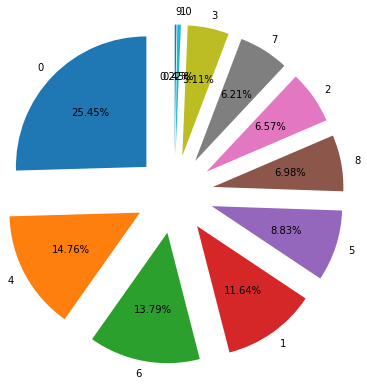

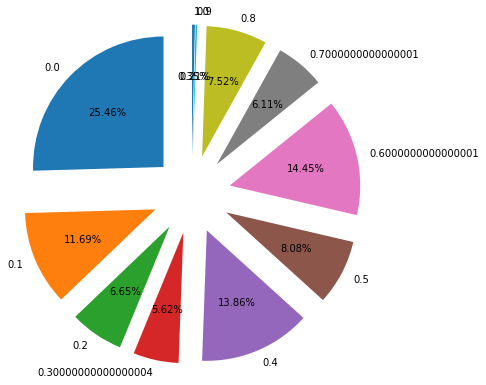

In [347]:
# 정제 전
plt.figure(figsize=(10,6))
plt.pie(
    x="occupation",
    data=pop_job_counts,
    labels=pop_job_counts["occupation_mapped"],
    autopct='%1.2f%%', # second decimal place
    startangle=90,
    explode=[0.3 for _ in range(11)]
)
plt.show()

# 정제 후
plt.figure(figsize=(10,6))
plt.pie(
    x="c_idx",
    data=oc_count,
    labels=oc_count["occupation"],
    autopct='%1.2f%%', # second decimal place
    startangle=90,
    explode=[0.3 for _ in range(11)]
)
plt.show()

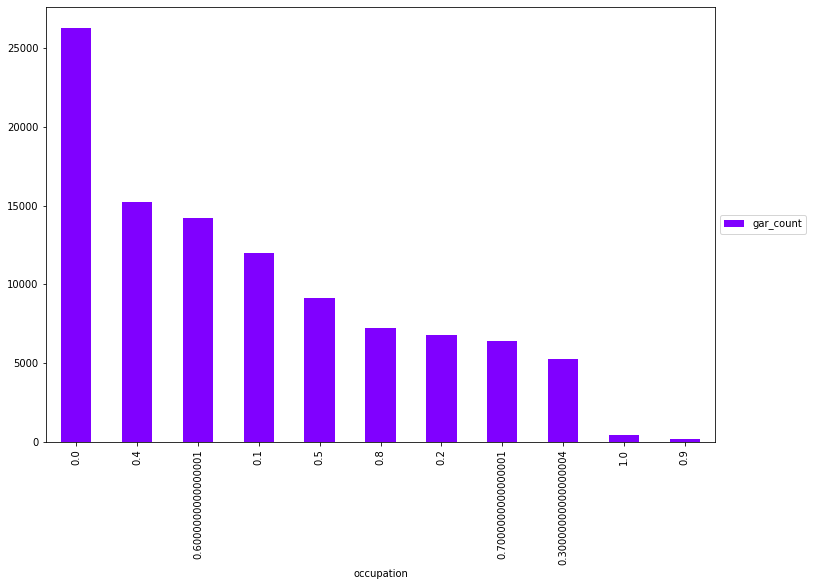

In [348]:
# 직업군별 특약 개수
# gar_count 형변환 object->int64
pop_df["gar_count"] = pop_df["gar_count"].astype(str).astype(int)
pop_df.groupby("occupation").sum()["gar_count"].sort_values(ascending=False).plot(
    kind='bar',
    stacked=True,
    colormap='rainbow',
    figsize=(12,8)).legend(loc='center left',
    bbox_to_anchor=(1, 0.5)
)

<BarContainer object of 11 artists>

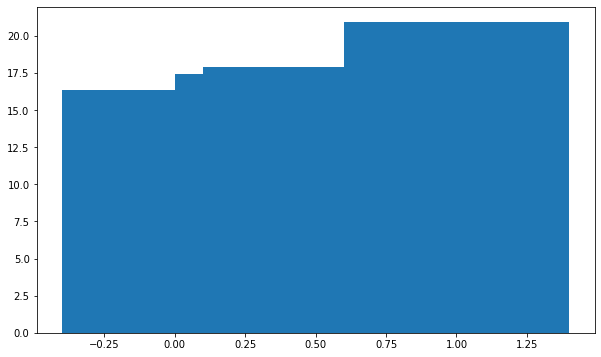

In [349]:
# 각 직업 1인당 특약 개수
rat=pop_df.groupby("occupation").sum()["gar_count"]/pop_df["occupation"].value_counts()
fig = plt.figure(figsize=(10,6))
plt.bar(rat.index,rat)

- age
 - child, young, adult, mid-age, senior 로 구분
 - child -> 고등학생 이전(~16세)
 - young -> 대학교졸업(17~26세)
 - adult -> 사회초년생 -> 과장급(27~36세)
 - mid-age -> 예상 은퇴 나이(37~57세)
 - senior -> 퇴직이후(58세~)

In [350]:
age_map = {'child':0,'young':1,'adult':2,'mid-age':3,'senior':4}
pop_df.loc[df["age"] <= 16, 'age'] = 0
pop_df.loc[(pop_df["age"] > 16) & (pop_df["age"] <= 26), 'age'] = 1
pop_df.loc[(df["age"] > 26) & (pop_df["age"] <= 36), 'age'] = 2
pop_df.loc[(df["age"] > 36) & (pop_df["age"] <= 57), 'age'] = 3
pop_df.loc[(df["age"] > 57),'age'] = 4

pop_df["age"].value_counts()

3    2468
4    1887
2    1173
1     538
0     247
Name: age, dtype: int64


# https://data.seoul.go.kr/dataList/11043/S/2/datasetView.do

- city-district
 - 전부 서울에 살고 있으므로 city는 제외
 - 사는 지역에서 차별점이 있는 변수는 자본수준(gis로 측정)
 - 자본수준과 보험을 들 수 있는 능력과 관계가 있다고 판단
 - district를 gdp//100000한 값으로 대체
 - MinMax scaler를 통해서 0~5 사이의 값으로 스케일링

In [351]:
with open("/content/drive/My Drive/insuretech/insurance/report.txt","r") as f:
  rows = f.read().split("\n")
city_gdp_map = {each.split("\t")[1]:int(each.split("\t")[2].replace(",",""))//100000 for each in rows[1:]}
pop_df["gis"] = pop_df["gis"].replace(city_gdp_map)
pop_df.head(10)

,c_idx,s_idx,sex,age,occupation,gis,ins_cat,ins_name,gar_count
0,2,26394,1,1,0.0,52,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,6
6,4,20024,0,1,0.0,28,장기/질병,무배당 프로미라이프 참좋은치아사랑보험1904,7
13,8,27841,0,1,0.0,71,장기/질병,무배당 프로미라이프 참좋은행복플러스+종합보험1911,24
37,15,16512,0,1,0.0,150,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,10
47,21,27840,1,1,0.0,71,장기/상해,무배당 프로미라이프 아이(I)러브(LOVE)건강보험2001,23
70,25,14177,0,0,0.0,119,장기/상해,무배당 프로미라이프 아이(I)러브(LOVE)건강보험2001,37
107,41,17679,0,4,0.0,277,장기/질병,무배당 프로미라이프 참좋은간편건강보험1906_TM,10
117,44,17112,0,4,0.1,107,장기/상해,무배당 프로미라이프 스마트가정보장보험1904,1
118,45,41013,0,4,0.2,52,장기/상해,무배당 프로미라이프 실손의료비보험(계약전환용)2001,6
124,47,14953,0,4,0.3,107,장기/운전자,무배당 프로미라이프 참좋은운전자보험(TM)1908,13


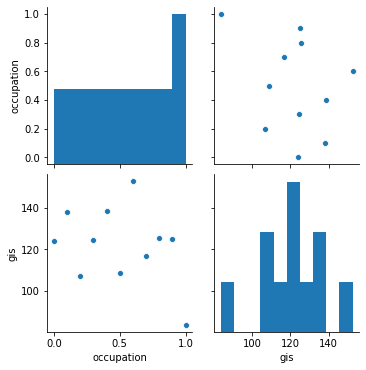

In [352]:
#직업 별 자본 수준
oc_gis=pop_df.groupby("occupation",as_index=False).mean()[["occupation","gis"]]

sns.pairplot(oc_gis)

In [353]:
#Min-Max scaler 정의
MAX = pop_df["gis"].max()
MIN = pop_df["gis"].min()
denom = MAX-MIN

def scaler(denom,min,x):
    return (x - min) / denom

pop_df["gis"] = pop_df["gis"].apply(lambda x: scaler(denom,MIN,x))

# 정규화 결과확인
pop_df["gis"].value_counts()

pop_df["gar_count"] = pop_df["gar_count"].apply(lambda x: scaler(denom,MIN,x))

# 정규화 결과확인
pop_df["gar_count"].value_counts()

-0.033275    1348
-0.043783     243
-0.042032     240
-0.047285     183
-0.022767     179
             ... 
 0.129597       1
 0.092820       1
 0.108581       1
 0.077058       1
 0.154116       1
Name: gar_count, Length: 88, dtype: int64

In [354]:
pop_df.head()

,c_idx,s_idx,sex,age,occupation,gis,ins_cat,ins_name,gar_count
0,2,26394,1,1,0.0,0.042032,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,-0.038529
6,4,20024,0,1,0.0,0.000000,장기/질병,무배당 프로미라이프 참좋은치아사랑보험1904,-0.036778
13,8,27841,0,1,0.0,0.075306,장기/질병,무배당 프로미라이프 참좋은행복플러스+종합보험1911,-0.007005
37,15,16512,0,1,0.0,0.213660,장기/운전자,무배당 프로미라이프 참좋은운전자+보험1908,-0.031524
47,21,27840,1,1,0.0,0.075306,장기/상해,무배당 프로미라이프 아이(I)러브(LOVE)건강보험2001,-0.008757


- ins_cat

In [355]:
pop_df["ins_cat"].value_counts()

# linspace를 통해서 데이터 매핑
#1번
#ins_cat_map = dict(zip(["장기/질병","장기/운전자","장기/상해","장기/재물","장기/저축"],np.linspace(0,1,5)))

#2번
ins_cat_map = dict(zip(["장기/질병","장기/운전자","장기/상해","장기/재물","장기/저축"],np.linspace(0,1,5)))
pop_df["ins_cat"] = pop_df["ins_cat"].replace(ins_cat_map)
pop_df["ins_cat"].value_counts()

0.50    2097
0.00    2072
0.25    1960
0.75     179
1.00       5
Name: ins_cat, dtype: int64

- ins_name
 - 총 56개의 보험중 상위 10개 제외 나머지 삭제

In [0]:
#isin메소드로 마스크제작
#각 보험별 수를 종합해서 랭킹 10위만 추출
pop_df = pop_df.loc[pop_df["ins_name"].isin(pop_df["ins_name"].value_counts().index[:10])]

In [357]:
pop_df

,c_idx,s_idx,sex,age,occupation,gis,ins_cat,ins_name,gar_count
0,2,26394,1,1,0.0,0.042032,0.25,무배당 프로미라이프 참좋은운전자+보험1908,-0.038529
6,4,20024,0,1,0.0,0.000000,0.00,무배당 프로미라이프 참좋은치아사랑보험1904,-0.036778
13,8,27841,0,1,0.0,0.075306,0.00,무배당 프로미라이프 참좋은행복플러스+종합보험1911,-0.007005
37,15,16512,0,1,0.0,0.213660,0.25,무배당 프로미라이프 참좋은운전자+보험1908,-0.031524
47,21,27840,1,1,0.0,0.075306,0.50,무배당 프로미라이프 아이(I)러브(LOVE)건강보험2001,-0.008757
...,...,...,...,...,...,...,...,...,...
103137,39914,41392,1,0,0.0,0.021016,0.50,무배당 프로미라이프 실손의료비보험2001,-0.033275
103147,39929,43614,0,1,0.0,0.080560,0.50,무배당 프로미라이프 실손의료비보험2001,-0.033275
103156,39930,46077,0,3,0.7,0.134851,0.25,무배당 프로미라이프 참좋은운전자+보험1908,-0.012259
103177,39931,46435,1,3,0.4,0.159370,0.25,무배당 프로미라이프 참좋은운전자보험(TM)1908,-0.012259


In [358]:
pop_df.groupby("occupation").sum()

,c_idx,s_idx,sex,age,gis,ins_cat,gar_count
occupation,,,,,,,
0.0,27306181,32541275,919,2861,224.129597,409.25,-23.462347
0.1,14043541,13407700,289,1640,111.691769,145.25,-10.105079
0.2,6838123,8182577,196,1051,46.817863,83.25,-6.348511
0.3,5162409,6333107,74,889,45.451839,61.25,-5.350263
0.4,16512860,16272791,347,1896,132.985989,173.75,-10.854641
0.5,7276501,10665911,19,1516,62.366025,103.75,-7.008757
0.6,14478762,16952875,215,2227,158.504378,175.00,-13.593695
0.7,6797708,7504578,39,1026,50.150613,67.00,-5.345009
0.8,8624643,8945280,230,1095,61.345009,90.25,-6.868651


In [359]:
# 직업 군별 점유율
pop_df["occupation"].value_counts()/pop_df["occupation"].value_counts().sum()*100

0.0    25.725900
0.6    14.324429
0.4    13.704994
0.1    11.420828
0.5     8.749516
0.8     7.200929
0.2     6.813782
0.7     6.252420
0.3     5.207123
1.0     0.406504
0.9     0.193573
Name: occupation, dtype: float64

In [360]:
# 질병,운전자,상해가 비슷한 특약 양상을 보임
pivot = pd.crosstab(pop_df["ins_cat"],pop_df["gar_count"]).sum(axis=1)
pivot

ins_cat
0.00    1582
0.25    1901
0.50    1683
dtype: int64

- randomforest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [0]:
pop_df = shuffle(pop_df)
data = pop_df.drop(['c_idx','s_idx','ins_name'], axis=1)
label = pop_df["ins_name"]

train_data, test_data, train_label, test_label = train_test_split(data,label)

train_data.to_excel("/content/drive/My Drive/insuretech/train_data.xlsx")
test_data.to_excel("/content/drive/My Drive/insuretech/test_data.xlsx")

train_label.to_excel("/content/drive/My Drive/insuretech/train_label.xlsx")
test_label.to_excel("/content/drive/My Drive/insuretech/test_label.xlsx")


In [363]:
test_data.head()
pd.crosstab(pop_df["age"],pop_df["ins_cat"])

ins_cat,0.00,0.25,0.50
age,,,
0,8,0,225
1,85,105,290
2,287,294,412
3,764,785,489
4,438,717,267


In [364]:
from sklearn import metrics

clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_data,train_label)
pre = clf.predict(test_data)
report = metrics.classification_report(pre,test_label)
print(report)

                                  precision    recall  f1-score   support

        무배당 프로미라이프 스마트가정보장보험1904       0.80      0.85      0.82        46
   무배당 프로미라이프 실손의료비보험(계약전환용)2001       0.33      0.58      0.42        24
          무배당 프로미라이프 실손의료비보험2001       0.93      0.84      0.88       246
무배당 프로미라이프 아이(I)러브(LOVE)건강보험2001       0.89      0.93      0.91        96
  무배당 프로미라이프 참좋은 훼밀리플러스+종합보험1911       0.26      0.41      0.32        83
        무배당 프로미라이프 참좋은간편건강보험1906       0.69      0.55      0.61       132
        무배당 프로미라이프 참좋은운전자+보험1908       0.91      0.77      0.83       416
     무배당 프로미라이프 참좋은운전자보험(TM)1908       0.19      0.40      0.26        55
        무배당 프로미라이프 참좋은치아사랑보험1904       0.68      0.47      0.56        40
    무배당 프로미라이프 참좋은행복플러스+종합보험1911       0.47      0.45      0.46       154

                        accuracy                           0.68      1292
                       macro avg       0.61      0.62      0.61      1292
                    weighted avg    